In [1]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation as PUNCTUATION
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from tqdm.notebook import tqdm
from tqdm import tqdm
from nltk.probability import FreqDist

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model_trf = spacy.load("en_core_web_trf")
model_sm = spacy.load("en_core_web_sm")

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\packaging\version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


## Load data

In [2]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset_TENDOC_tokenized.pkl")
data.head()

,filename,date,full_text,selected_sections,full_text tokenized filtered,selected_sections tokenized filtered
0,1347 - EN-Annex II - ToR.pdf,10-03-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,1. \n\nTerms and Definitions \n\n \n\nThe term...,january ref jl myfrontex digital workplace cot...,term definitions term table appear complete ab...
1,1415 - EN-Annex II_Terms of Reference_OP_87_20...,30-03-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,1. General Information \n \n1.1. Overview \n...,annex ii term reference tor frontex data centr...,general information overview subject maintenan...
2,1456 - EN-Annex II TOR-FWC-SPServices2016-19.pdf,30-04-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,1. \n\nTerms and Definitions \n\nFWC \n\nThe t...,ref frontex ah annex ii framework contract sha...,term definitions fwc term table appear complet...
3,1507 - EN-Annex II - Terms of Reference.pdf,07-05-2016,\n \n\n \n \n \n \n \n \n \n\n \n \n \n \n\n ...,1. Background Information \n\nNational (PL) \n...,tender procedure frontex jl courier post servi...,background information national pl eu country ...
4,1556 - EN-Annex II_Terms of Reference_OP_286_2...,27-05-2016,\n\n \n \n \n\n \n\n \n\nAnnex II \n\n \n\n ...,1 \n\nSituation Monitoring and supporting IT s...,annex ii term reference frontex rs purchase di...,situation monitoring support system frontex es...


Text(0.5, 1.0, 'Number of documents per year')

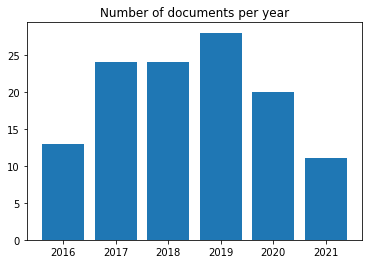

In [3]:
from collections import Counter
count_dict = Counter([x[-1] for x in data["date"].str.split("-")])
plt.bar(count_dict.keys(), count_dict.values())
plt.title("Number of documents per year")

## Tokenization

In [19]:
def tokenize(sample, model_type="sm"):
    if not sample:
        return None
    
    if model_type == "sm":
        model = model_sm
    elif model_type == "trf":
        model = model_trf
    else:
        print("Error invalid model type!")
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS and len(token_processed) > 0:
                if token_processed not in PUNCTUATION:
                    tokens.append(token_processed)        
    return " ".join(tokens)

def filter_tokens(tokenized_text):
    split_text = tokenized_text.split(" ")
    output = []
    for token in split_text:
        if len([char for char in token if char.isdigit()]) == 0:
            output.append(token)
            
    return " ".join(output)

def split_text(text, desired_part_length=100000):
    """
    Splits a text into roughly equal parts of a given length.
    Only splits on whitespace.
    """
    
    length = len(text)
    n_parts = length // desired_part_length
    steps = length // n_parts

    parts = []
    start = 0 
    end = 0
    for _ in range(n_parts - 1):
        end = end + steps
        # make sure to split on whitespace to not mess up tokenization
        for i in range(end, length):
            if text[i] in [" ", "\n"]:
                end = i
                break

        parts.append(text[start:end])
        start = end

    parts.append(text[start:length])
    return parts

In [ ]:
# add a new column to the dataset, namely the tokenized and filtered full_text of the documents
tokenized_full_text = []
for ft in tqdm(data["full_text"]):
    length = len(ft)
    if length > 100000:
        # split the text for memory management reasons (the spacy models
        # of large documents use a large amount of memory)
        parts = split_text(ft)
        tokenized_parts = [tokenize(part) for part in parts]
        tokenized = "".join(tokenized_parts)
    else:
        tokenized = tokenize(ft)
    tokenized_full_text.append(filter_tokens(tokenized))
    
data["full_text tokenized filtered"] = tokenized_full_text

# save the dataset (as a checkpoint as to not loose lots of work if something goes wrong)
data.to_pickle(DATA_PATH + "/processed/dataset_TENDOC_tokenized.pkl")

# add a new column to the dataset, namely the tokenized and filtered selected_sections of the documents
tokenized_selected_sections = []
for ss in tqdm(data["selected_sections"]):
    length = len(ss)
    if length > 100000:
        # split the text for memory management reasons (the spacy models
        # of large documents use a large amount of memory)
        parts = split_text(ss)
        tokenized_parts = [tokenize(part) for part in parts]
        tokenized = "".join(tokenized_parts)
    else:
        tokenized = tokenize(ss)
    tokenized_selected_sections.append(filter_tokens(tokenized))
    
data["selected_sections tokenized filtered"] = tokenized_selected_sections

# save the dataset
data.to_pickle(DATA_PATH + "/processed/dataset_TENDOC_tokenized.pkl")

## Preprocess data

In [4]:
%%time
# filter datapoints with invalid or missing descriptions
column_name = "selected_sections tokenized filtered"
no_invalid = data[data[column_name].notna()].reset_index(drop=True)
corpus = no_invalid[column_name]

# vectorize data, that is create matrix of word count per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(corpus)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

Wall time: 31.5 s


## Find optimal hyperparameters

In [5]:
%%time
log_likelihoods = []
perplexities = []
coherences = []
ks = list(range(2, 50))
for i in tqdm(ks):
    lda = LatentDirichletAllocation(n_components=i, learning_method='online')
    data_lda = lda.fit_transform(data_vectorized.toarray())
    
    coherence = metric_coherence_gensim(
        measure='u_mass',
        topic_word_distrib=lda.components_,
        dtm=data_vectorized.toarray(),
        vocab=np.array(vectorizer.get_feature_names())
    )
    coherences.append(np.mean(coherence))
    
    log_likelihoods.append(lda.score(data_vectorized))
    perplexities.append(lda.perplexity(data_vectorized))

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [08:03<00:00, 10.07s/it]

Wall time: 8min 3s


3 highest log likelihoods: [-2065985.16430969 -2074952.70212156 -2075840.17338355]
Associated k's: [7, 4, 11]


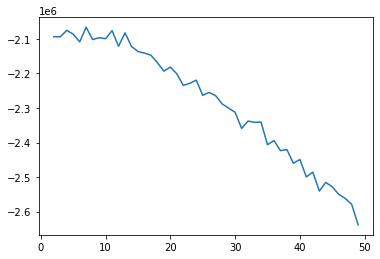

In [6]:
plt.plot(ks, log_likelihoods)

top_n = 3
print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [1243.13165091 1282.1802091  1286.11072505]
Associated k's: [7, 4, 11]


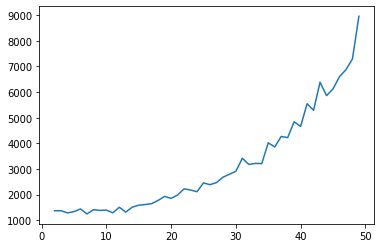

In [7]:
plt.plot(ks, perplexities)

top_n = 3
print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

10 highest cv coherence: [-0.28887305 -0.32870556 -0.36727877 -0.39121722 -0.41570411 -0.41803999
 -0.4492338  -0.46069658 -0.46976905 -0.49447367]
Associated k's: [2, 4, 13, 8, 41, 18, 39, 36, 24, 32]


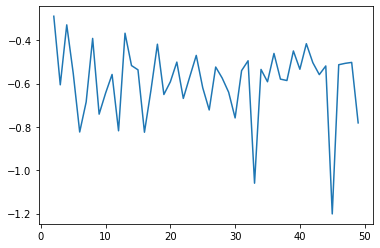

In [8]:
plt.plot(ks, coherences)

top_n = 10
print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [14]:
%%time
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=10, learning_method='online', verbose=0, max_iter=10)
lda.fit(data_vectorized)

Wall time: 7.82 s


In [40]:
# transform data
data_lda = lda.transform(data_vectorized)

#### Save model

In [67]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scitkitLDA_TENDOC_selected_sections_k10-1.pkl", "wb") as f:
    pickle.dump(lda, f)

#### Load model

In [38]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scitkitLDA_TENDOC_selected_sections_k10-1.pkl", "rb") as f:
    lda = pickle.load(f)

## Visualize topics

In [41]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False)

# export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/scikitLDA7_plot.html')

# show plot
plot

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       79.026619  -47.510689       1        1   0.167613
1      136.441071 -149.391281       2        1   0.615410
2      188.787033   -2.707141       3        1   1.228074
3      122.386543  114.475433       4        1  24.120675
4       -1.163786 -167.593506       5        1  38.604679
5       21.621487   50.796619       6        1   0.606310
6     -117.633377   47.857506       7        1  15.742841
7     -137.851990 -100.605103       8        1   3.033233
8      -27.611361  156.305527       9        1  14.579846
9      -35.013039  -48.143501      10        1   1.301320, topic_info=             Term         Freq        Total Category  logprob  loglift
6725        shall  4831.000000  4831.000000  Default  30.0000  30.0000
3036      frontex  6597.000000  6597.000000  Default  29.0000  29.0000
6695      service  3562.000000  3562.000000  Default  28.0000  28.0000
1519   contractor  3836.000000  3836.000000  Default  27.0000  27.0000
1516     contract  2679.000000  2679.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
6695      service    12.401269  3562.839777  Topic10  -5.7179  -1.3187
7546         time    11.258871  1157.756123  Topic10  -5.8145  -0.2913
4518         meet    10.512094   271.331844  Topic10  -5.8831   1.0910
6725        shall    10.869051  4831.372943  Topic10  -5.8497  -1.7552
6250  requirement    10.446241  1257.224656  Topic10  -5.8894  -0.4486

[737 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9         2  0.043907  ability
9         3  0.006272  ability
9         4  0.150537  ability
9         5  0.564512  ability
9         6  0.006272  ability
...     ...       ...      ...
8324      4  0.455819     yyyy
8324      7  0.065117     yyyy
8324     10  0.390702     yyyy
8330      5  0.047258       zb
8330      7  0.897909       zb

[2640 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [52]:
# name topics
topic_names_k9 = {
    1 : 'fresh food',
    2 : 'border checkpoint',
    3 : 'branding',
    4 : 'software',
    5 : 'organised events',
    6 : 'surveillance',
    7 : 'weather/maps',
    8 : 'crisis management',
    9 : 'local operational support'
}

topic_names_k10 = {
    1 : 'hardware',
    2 : 'staff',
    3 : 'vehicles',
    4 : 'surveillance/information systems',
    5 : 'software',
    6 : 'facilities',
    7 : 'organised events',
    8 : 'weapons',
    9 : 'surveillance',
    10 : 'infrastructure'
}

topic_names = topic_names_k10

Document distribution


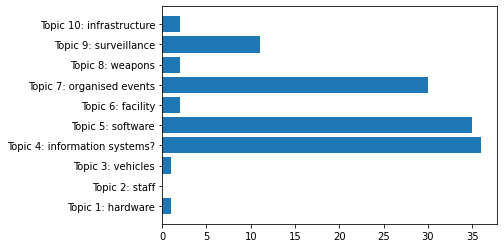

In [45]:
# docments per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
print("Document distribution")

In [33]:
def describe_doc(doc_id, word_dist_plot=True, plot=True):
    print("filename:")
    print(data["filename"].iloc[doc_id])
    
    fdist = FreqDist(data["full_text tokenized filtered"].iloc[doc_id].split(" "))
    fig = plt.figure(figsize = (8,4))
    fdist.plot(30)

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 60
filename:
3751 - EN-Annex II Terms of Reference (corrected after QA).pdf


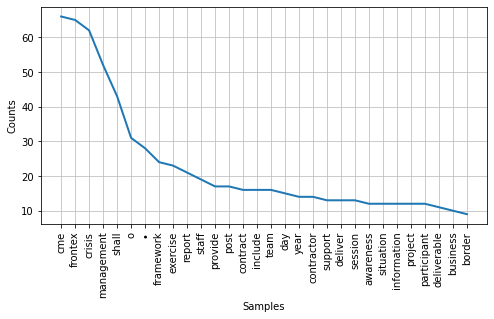


Topics (ranked):


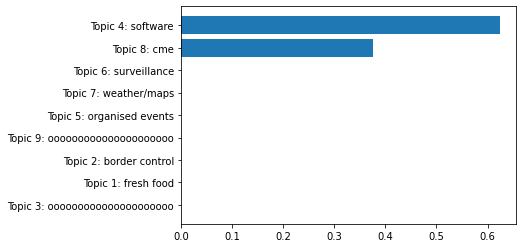

In [34]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(data["full_text"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(43)

Topic: 4 - information systems?
Number of documents for this topic: 36

doc_id: 36
filename:
3080 - EN-Annex II - ToR.pdf


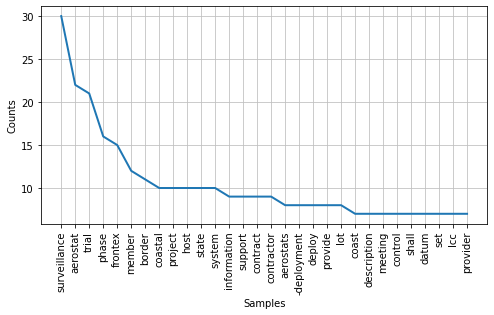


Topics (ranked):
doc_id: 65
filename:
4558 - EN-Annex II_Terms of Reference_OP_1499_2018_RS.pdf


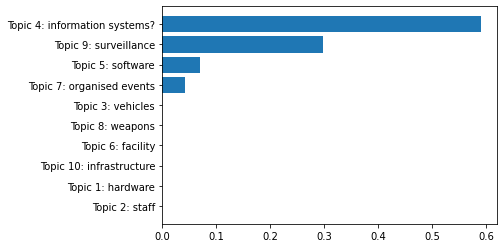

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 61607 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 61607 missing from current font.
  font.set_text(s, 0, flags=flags)


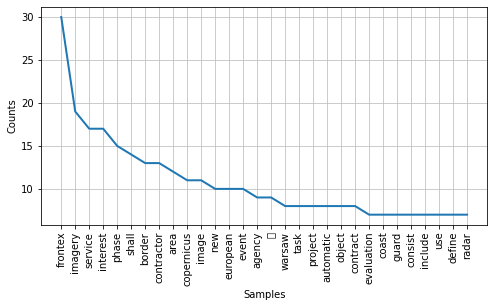


Topics (ranked):
doc_id: 37
filename:
3346 - EN-Annex II_Terms of Reference.pdf


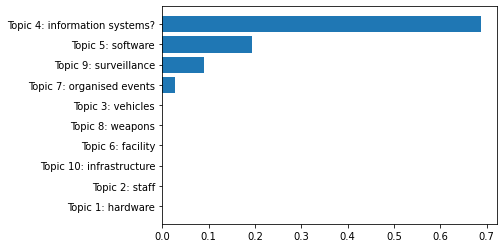

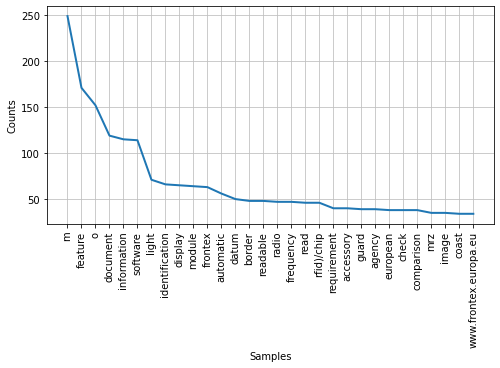


Topics (ranked):
doc_id: 16
filename:
2367 - EN-Annex II_Terms of Reference_OP_141_2017_RS.pdf


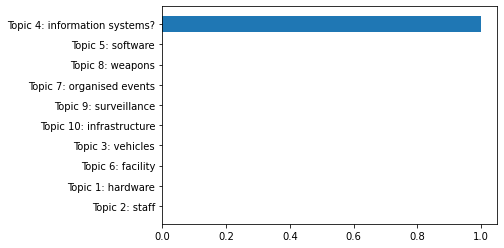

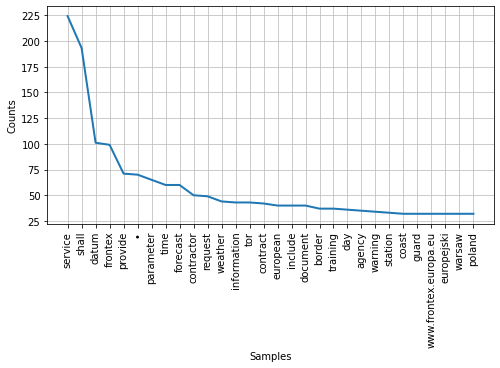


Topics (ranked):
doc_id: 68
filename:
4735 - EN-Annex II - Terms of Reference.pdf


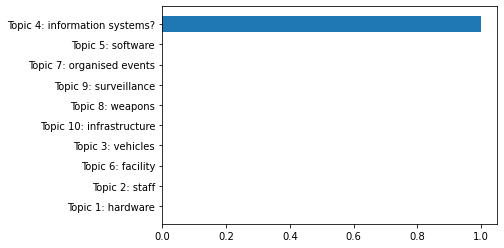

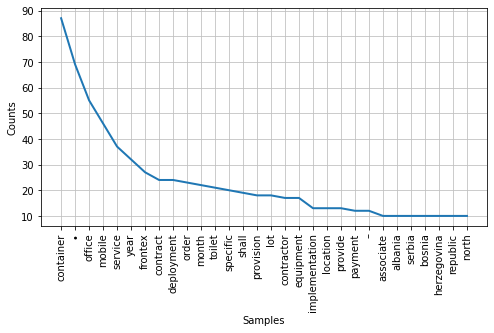


Topics (ranked):
doc_id: 102
filename:
7133 - EN-Annex I - Information to Candidates.pdf


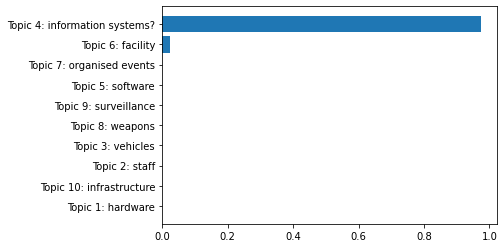

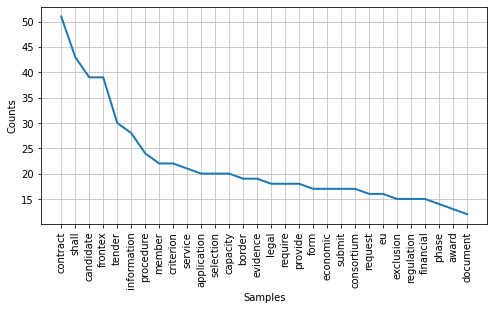


Topics (ranked):
doc_id: 25
filename:
2906 - EN-Annex II_Terms of Reference_796.pdf


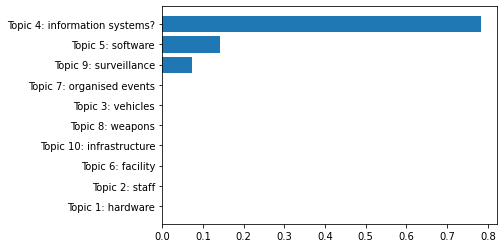

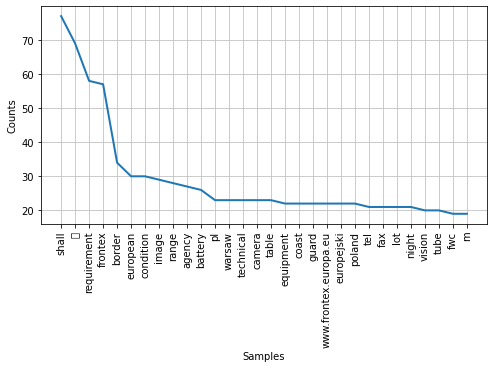


Topics (ranked):
doc_id: 97
filename:
6954 - EN-Annex II_1 Terms of Reference EES Land Bulgaria.pdf


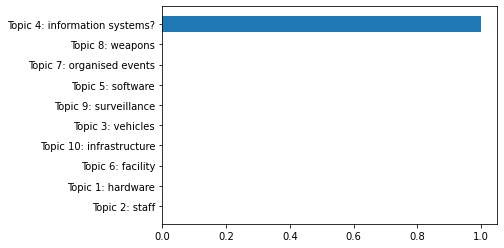

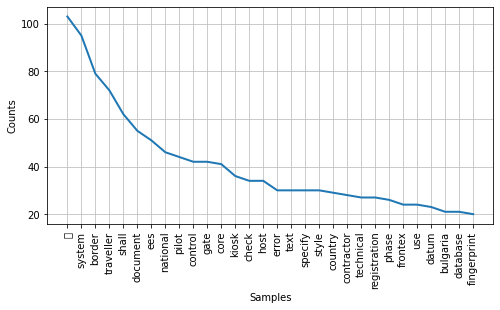


Topics (ranked):
doc_id: 109
filename:
7547 - EN-Annex II - Technical Specifications.pdf


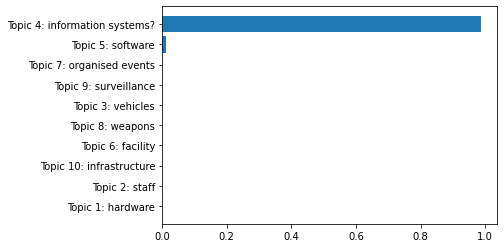

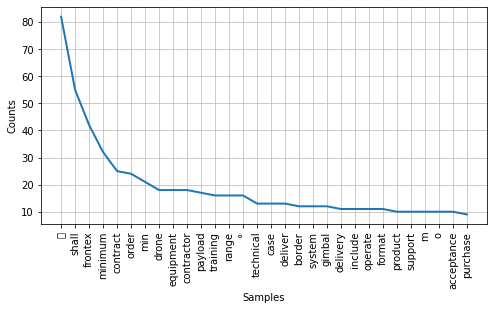


Topics (ranked):
doc_id: 11
filename:
2062 - EN-Annex II - TS_ENG.pdf


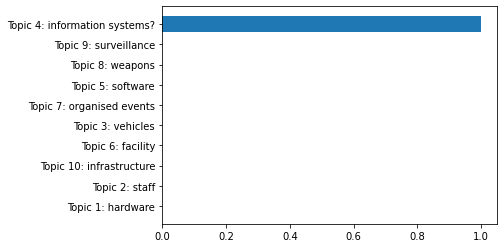

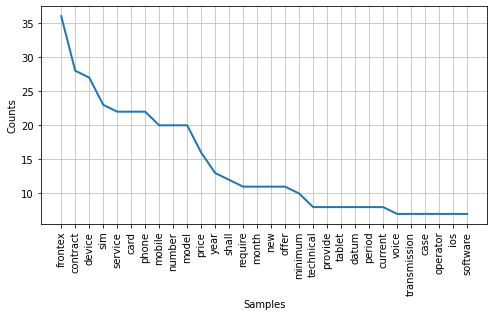


Topics (ranked):


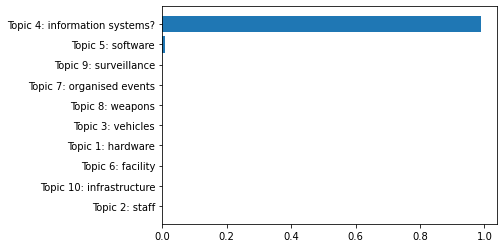

In [49]:
# For a given topic sample a random document
topic_n = 4
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=10):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)

## Topic distribution per year

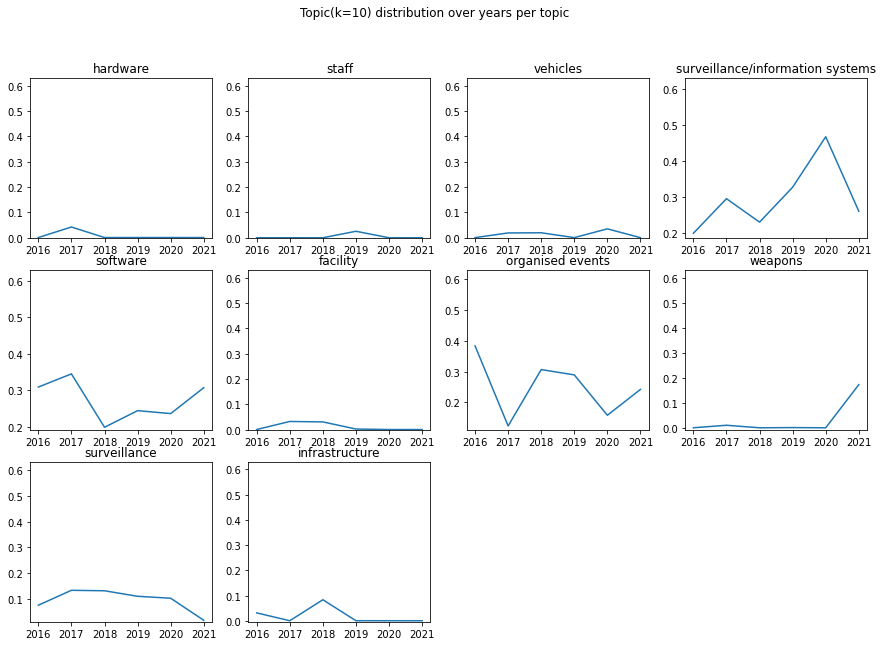

In [51]:
# create topic distribution per year
topic_dist_years = []
for year in [str(y) for y in range(2016, 2022)]:
    ids = data[data["date"].str.contains(year)].index
    topic_dist = np.mean(data_lda[ids], axis=0)
    topic_dist_years.append(topic_dist)
    
    
# plot the distribution of each topic over the years
fig = plt.figure(figsize = (15,10))
plt.suptitle("Topic(k=10) distribution over years per topic")
fig.tight_layout(pad=1.0)
for topic_index in range(len(data_lda[0])):
    plt.subplot(3,int(np.ceil(len(data_lda[0])/3)), topic_index+1)
    plt.plot(list(range(2016, 2022)), [x[topic_index] for x in topic_dist_years])
    plt.title(topic_names[topic_index+1])
    plt.ylim(top=0.63)

In [102]:
np.sum(data["selected_sections tokenized filtered"].str.split(" ").str.len())

297220

In [31]:
for i in range(len(data)):
    l = data.iloc[i]["selected_sections tokenized filtered"].split(" ")
    if "cme" in l:
        print(i)
        print(data.iloc[i]["filename"])
        

43
3751 - EN-Annex II Terms of Reference (corrected after QA).pdf
